Idea: supplement a traditional recommendation system with an LLM that generates a customized recommendation tip for each recommendation. 

Demonstration: user either picks a specific node in the network or a random one. Generate info about this user. Generate the product recommendation with tip (top-k times). If ambitious we could set up a user-friendly front-end demo with an app or something. 

TODO: 

- build graph  - [x] 
- recommendation algorithm, which must return for a User u: - [x]
    - top-k recommended products p1, p2 etc.
    - N set of most similar users v
- From this we find for each  
    - Product pi and User ui:
        - M set of top-l highest rated and most helpful reviews for pi by ui
- O set of u's reviews with highest rating of products q, r etc. that were also rated highly by the M set users, i.e. products on which the similarity is based. This is to give the LLM (a) info about which products u likes and (b) u's writing style. 
- Prompt packaging: 
    - We generate a prompt that contains the following information:
        1. Description of task. 
        2. M set sorted by rating and helpfulness. 
        3. O set sorted by rating. 



# 0. Functions and Global Directories

In [67]:
import os 
import gzip 
import json
import networkx as nx 
import numpy as np

cwd = os.getcwd()
project_dir = os.path.dirname(cwd)
print(project_dir) 
data_dir = os.path.join(project_dir, "data")
data_path = os.path.join(data_dir, "Musical_Instruments_5.json.gz") 
print(os.path.exists(data_path))
lookups_dir = os.path.join(project_dir, "lookups") 
graphs_dir = os.path.join(project_dir, "graph") 

c:\Users\bened\DataScience\Autumn 2025\SINA\assignments\3
True


In [68]:
os.listdir(project_dir)

['.env',
 '.git',
 '.gitignore',
 'data',
 'environment.yml',
 'graph',
 'info',
 'lookups',
 'notebooks',
 'reading',
 'scripts',
 'setup']

In [14]:
def parse(path): 
    g = gzip.open(path, 'r') 
    for l in g:
        yield json.loads(l) 

In [15]:
def create_graph(path): 

    product_keys = ['image', 'style']
    edge_keys = ['overall', 'verified', 'vote', 'reviewText', 'summary', 'reviewTime', 'unixReviewTime']

    G = nx.DiGraph() 
    for idx, review in enumerate(parse(path)):  
        
        # -- EXTRACT NODE IDs AND ATTRIBUTES --- 
        user_id = review['reviewerID'] 
        if 'reviewerName' in review:
            user_name = review.get('reviewerName', None) 
        
        product_id = review['asin'] 

        # --- USER NODE --- 
        if G.has_node(user_id): 
            # Node exists; check names 
            current_name = G.nodes[user_id].get('reviewerName', None) 

            if user_name:  # if the dict has a reviewerName (not None) 
                if not current_name:  # and the node corresponding to that reviewerID does not have a name already
                    G.nodes[user_id]['reviewerName'] = user_name  # name reviewer 
                # else if there's a conflict between node's current name and name on this review
                elif user_name != current_name: 
                    # add an additional name attribute
                    name_keys = [k for k in G.nodes[user_id] if 'Name' in k] # by first checking how many names the node already has 
                    count = len(name_keys) 
                    key = "secondName" if count == 2 else f"{count}thName" 
                    G.nodes[user_id][key] = user_name 
                # if user_name is None we do nothing
        # if no existing node for this user_id, create a new one 
        else: 
            G.add_node(user_id, bipartite='user') 
            if user_name: 
                G.nodes[user_id]['reviewerName'] = user_name 
        
        # --- PRODUCT NODES --- 
        if not G.has_node(product_id): 
            product_attributes = {k:v for k, v in review.items() if k in product_keys}
            G.add_node(
                product_id, 
                bipartite='product',
                **product_attributes
                ) 
        # check if review has attributes not already stored in in this node 
        else: 
            for k in product_keys: 
                val = review.get(k, None) 
                if val is not None and k not in G.nodes[product_id]: 
                    G.nodes[product_id][k] = val
        # --- REVIEW EDGES (User-Review->Product) --- 
        edge_attributes = {k:v for k, v in review.items() if k in edge_keys}
        G.add_edge(
            user_id, 
            product_id, 
            type='Reviewed',
            id=idx, 
            **edge_attributes
        )

    return G

# 1. Data Inspection

## 1.0. Dimensions

### 1.0.0. Total number of reviews

In [16]:
num = 0 
for review in parse(data_path): 
    num += 1 
print(f"{num} reviews total in data.")

231392 reviews total in data.


### 1.0.1. Total number of distinct products

In [17]:
distinct_products = set() 
for review in parse(data_path): 
    if 'asin' in review: 
        distinct_products.add(review.get('asin', None)) 
print(f"{len(distinct_products)} distinct products in data.")

10620 distinct products in data.


### 1.0.2. Total number of distinct reviewer IDs. 

In [18]:
distinct_reviewers = set() 
for review in parse(data_path): 
    if 'reviewerID' in review: 
        distinct_reviewers.add(review.get('reviewerID', None)) 
print(f"{len(distinct_reviewers)} distinct reviewers in data.")

27530 distinct reviewers in data.


### 1.0.3. Top Reviewers

In [ ]:
from collections import Counter 



## 1.1. Possible Keys (-> attributes)

In [113]:
# inspect possible keys 
keys = set() 

for review in parse(data_path): 
    for k in review.keys(): 
        if k not in keys: 
            keys.add(k) 

print(keys) 

{'reviewTime', 'reviewerName', 'style', 'summary', 'verified', 'overall', 'reviewText', 'vote', 'asin', 'reviewerID', 'image', 'unixReviewTime'}


## 1.2. ReviewTime

In [5]:
# inspect reviewTime field 
for idx, review in enumerate(parse(data_path)): 
    if idx==10: 
        break 
    elif 'reviewTime' in review: 
        print(review['reviewTime'])

10 30, 2016
06 30, 2016
05 9, 2016
04 10, 2016
02 6, 2016
01 2, 2016
06 21, 2015
03 28, 2015
03 19, 2015
03 15, 2015


format: MM DD, YYYY  

Since we have Unix already this is likely not needed for any computational task. 

## 1.3. Style

In [6]:
# style field 
styles = {}

for review in parse(data_path): 
    if 'style' in review: 
        for k, v in review['style'].items(): 
            if k in styles:
                styles[k].add(v) 
            else: 
                styles[k] = set(v) 

for k, v in styles.items(): 
    print(f"{k}: {v}")

Format:: {' Misc. Supplies', 'S', ' Wireless Phone Accessory', 'M', ' CD-ROM', ' Software Download', 'u', ' DVD-ROM', 'c', ' Audio CD', ' Paperback', 'l', 'e', 's', ' Electronics', ' ', 'p', 'i', '.'}
style:: {' 49 Key', ' AUD ATR1500', ' GXL3000BP', ' G3X', ' B Band', ' TVHF: 179.400 MHz & 180.600 MHz', ' 200 W, 8 Ohm', ' 8PreX - 26 in / 28 out', ' 4FX', ' Dirt Transmitter Fuzz', ' GX7 1000W Amp', ' Line/Inst level input switchable, 4 ch rackmount', ' 25-Pin to 8XLRM, 5 ft', ' HT Venue Club 40 Combo Amplifier', ' Tone Job', ' Supercardioid', ' 2Pre - 10 in / 4 out', ' Bluetooth Enabled', ' 5-Watt Limited Edition', ' Pedal', ' 200 W, 4 Ohm', ' MG15 Stack', ' Loudbox Artist Cover', ' 4-Piece Drum Pack', ' Straight to Right Angle', ' NP-2', ' Archer Overdrive/Boost', ' G3', ' Lightning', ' C9', ' 7.2-inch', ' No Bluetooth', ' H4n (2015 model)', ' 5" Monitor Speaker', ' 18W PAR', ' Korg ELECTRIBES Sample Based Production Station', ' 15 Watt Amp', ' Headphone', ' APC Key 25', ' AK-DR11C', 

The style field does likely contain info relevant to recommendation tips. 

## 1.4. Overall

Mean rating: 4.47
Median rating: 4.47
Max rating: 5.0
Min rating: 4.47
Standard deviation: inf


c:\Users\bened\anaconda3\envs\SINA-AT3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


(array([  7465.,      0.,   7277.,      0.,      0.,  16030.,      0.,
         38783.,      0., 161837.]),
 array([1.        , 1.40039062, 1.79980469, 2.19921875, 2.59960938,
        3.        , 3.40039062, 3.80078125, 4.19921875, 4.6015625 ,
        5.        ]),
 <BarContainer object of 10 artists>)

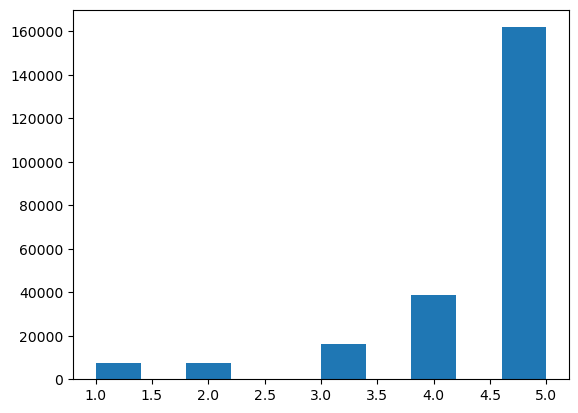

In [ ]:
from matplotlib import pyplot as plt 

# collect all Overall values 
ratings = [] 
for review in parse(data_path): 
    if 'overall' in review: 
        ratings.append(np.float16(review.get('overall', np.nan))) 

Mean rating: 4.47
Median rating: 4.47
Max rating: 5.0
Min rating: 1.0
Standard deviation: inf


(array([  7465.,      0.,   7277.,      0.,      0.,  16030.,      0.,
         38783.,      0., 161837.]),
 array([1.        , 1.40039062, 1.79980469, 2.19921875, 2.59960938,
        3.        , 3.40039062, 3.80078125, 4.19921875, 4.6015625 ,
        5.        ]),
 <BarContainer object of 10 artists>)

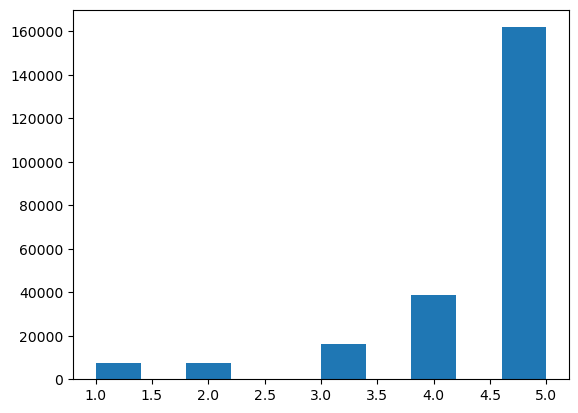

In [6]:

# mean 
print("Mean rating:", np.mean(ratings)) 
# median 
print("Median rating:", np.mean(ratings)) 
# max 
print("Max rating:", np.max(ratings)) 
# min 
print("Min rating:", np.min(ratings)) 
# std 
print("Standard deviation:", np.std(ratings))

plt.hist(ratings) 

In [7]:
# grab a sample of each rating value 
sample_set = {
    1: "", 
    2: "", 
    3: "", 
    4: "", 
    5: ""
}
for review in parse(data_path): 
    if all(sample_set.values()):
        break
    elif 'overall' in review: 
        rating = int(review['overall']) 
        sample_set[rating] = review.get('reviewText', "") 
    else: 
        continue 

print("Sample of review ratings:") 
for rating, review in sample_set.items(): 
    print(rating, ":", review) 
        

Sample of review ratings:
1 : Great concept with great instructions and CDs.  The ukulele looks nice but the chords are frustratingly out of tune even with the strings tuned.
2 : Had to return this item. After it had been tuned and sat overnight, the neck tore away from the body of the instrument. The instruction book is very good for beginners.
3 : Good basic guide.
4 : good starter set up
5 : My 14 yr. old daughter already had a ukelele that I bought on Amazon a few years ago for about the same price ($34.95), but without all the accessories that this one comes with! She's planning to give this one to her best friend for her birthday soon. Learning to play a uke is pretty easy, and it makes it easier to learn to play the guitar later on!


Based on this very cursory overview, overall=3 seems like a reasonable cut-off point for forming a recommendation edge. (remember that we need to denormalize ratings values though). For a more rigorous approach we could integrate sentiment analysis. 

## 1.5. Product Metadata 

In [20]:
from IPython.display import display, HTML 

data_dir = os.path.join(project_dir, "data")
metadata_path = os.path.join(data_dir, "meta_Musical_Instruments.json.gz") 

def show_field(field, path=metadata_path, html=False, num_samples=1): 
    i = 0
    for product in parse(metadata_path):
        if i == num_samples: 
            break 
        elif product.get(field): 
            i += 1
            if html: 
                display(HTML(product.get(field))) 
            else: 
                print(product.get(field)) 
        else: 
            continue

In [48]:
ignore_fields = [] 

In [49]:
ignore_fields.append('asin') 

In [50]:
# treat also_buy and also_view as edges rather than attributes
ignore_fields.extend(['also_view', 'also_buy']) 

### 1.5.0. Possible Keys

Inspect possible keys

In [24]:
# inspect possible keys 
meta_keys = set() 

for product in parse(metadata_path): 
    for k in product.keys(): 
        if k not in meta_keys: 
            meta_keys.add(k) 

In [25]:
for key in meta_keys:
    print(key)

rank
tech2
main_cat
tech1
date
brand
also_view
fit
title
imageURL
price
category
details
feature
similar_item
description
also_buy
asin
imageURLHighRes


### 1.5.1. feature

In [26]:
show_field('feature')

['Wood percussion', 'Owl whistle*', 'Includes wooden scraper', 'Small 3"', 'Age rating: 3+']


keep feature field

### 1.5.2. fit

In [27]:
show_field('fit', html=True)

Too small,,0
Somewhat small,,1
Fits as expected,,8
Somewhat large,,0
Too large,,0


disregard fit

In [51]:
ignore_fields.append('fit') 

### 1.5.3. rank

In [29]:
show_field('rank')

['>#141,729 in Musical Instruments (See Top 100 in Musical Instruments)', '>#95 in Musical Instruments > Drums & Percussion > Hand Percussion > Folk & World > Latin Percussion > Guiros']


'rank' could be useful to selling the item. 

### 1.5.6. tech tables

In [31]:
show_field('tech1', html=True)

Brand Name,Teacher's Discovery
Color,_
Manufacturer Part Number,1Z0160


In [32]:
show_field('tech2', html=True)

Brand Name,Tascam
Item model number,DVW/D17A/KIT/H/TAS
Item Weight,3 pounds
Product Dimensions,23 x 25 x 15 inches
Item Dimensions L x W x H,23 x 25 x 15 inches


disregard the two tech fields

In [52]:
ignore_fields.extend(['tech1', 'tech2'])

### 1.5.7. similar_item

In [34]:
show_field('similar_item', html=True)

,This item Ukulele Chord Changer and Songbook Set,"BoloPick Felt Ukulele Picks Economy 12 Pack, Multi Fiesta #1 Best Seller",CLOUDMUSIC Pineapple Ukulele Strap with Hook Hawaiian Tropical Design Ukulele Strap no drilling For Soprano Concert Tenor Ukulele (Pineapples in Blue),"HOT SEAL 10MM Sponge Padding Waterproof Durable Colorful Conventional ukulele Case Bag with Storage (23/24 in, Bohemia NO.2)",Double Use Adjustable Nylon Ukulele Strap - Can be Use as Ukulele Neck Strap or Ukulele Shoulder Strap (BLACK)
,,"<a id=""comparison_add_to_cart_button0-announce"" href=""/gp/item-dispatch/ref=psdc_11968841_a1_0692218645?ie=UTF8&itemCount=1&nodeID=11091801&offeringID.1=UK%252F3X8Wmm9ZiV5RTzWBhft%252BWwpBJHm2C%252BZdupUl7dZJGuK28qZls0EyOENmrWl%252BN58nE%252FHNTPGJpixaY%252B9VI1CY8q8yVd%252BkCo9ph0GeTD%252F64uMWVW%252BJl60MfOnT2MIHHhXV%252FVbA5Gkk9rvdq%252FK8%252BvA%253D%253D&storeID=musical-instruments&session-id=131-2701147-5306408&submit.addToCart=addToCart&signInToHUC=0"" class=""a-button-text"" role=""button"">Add to Cart",Add to Cart,Add to Cart,Add to Cart
Customer Rating,3 out of 5 stars (15),4 out of 5 stars (32),4 out of 5 stars (103),4 out of 5 stars (86),4 out of 5 stars (9)
Price,From $32.00,$7.25$725,$10.99$1099,$18.96$1896,$10.95$1095
Shipping,,Eligible for FREE Shipping,Eligible for FREE Shipping,Eligible for FREE Shipping,Eligible for FREE Shipping
Sold By,Available from these sellers,"BoloPick, LLC",CloudMusic Direct,Sunny&Quality,ZSFLZS
Color,White,Multi Color Fiesta,Pineapples,Bohemia NO.2,BLACK


we'll disregard the similar_item field

In [53]:
ignore_fields.append('similar_item') 

In [36]:
meta_keys

{'also_buy',
 'also_view',
 'asin',
 'brand',
 'category',
 'date',
 'description',
 'details',
 'feature',
 'fit',
 'imageURL',
 'imageURLHighRes',
 'main_cat',
 'price',
 'rank',
 'similar_item',
 'tech1',
 'tech2',
 'title'}

### 1.5.8. main_cat

In [37]:
show_field('main_cat') 

Musical Instruments


In [38]:
for review in parse(metadata_path): 
    if review.get('main_cat'): 
        print(review.get('main_cat')) 
        break

Musical Instruments


disregard main_cat

In [59]:
ignore_fields.append('main_cat')

### 1.5.9. details

to be really meticulous we'd need to exclude any products with 'Discontinued by manufacturer' == 'Yes' in 'Details'

In [54]:
show_field('details', num_samples=3)

{'Audio CD': '(June 24, 1997)', 'Number of Discs:': '1', 'Label:': 'Tooth & Nail Records', 'ASIN:': 'B000003ZGU'}
{'Shipping Weight:': '3.2 ounces', 'ASIN:': 'B00002EIWR', 'Item model number:': '2026286', ' Date first listed on Amazon:': 'February 2, 2002', 'Discontinued by manufacturer:': 'Yes'}
{'Shipping Weight:': '1.3 pounds', 'ASIN:': 'B00002K149', ' Date first listed on Amazon:': 'March 20, 2010'}


In [55]:
# disregard 
ignore_fields.append('details') 

In [56]:
ignore_fields.append('date')

In [43]:
meta_keys

{'also_buy',
 'also_view',
 'asin',
 'brand',
 'category',
 'date',
 'description',
 'details',
 'feature',
 'fit',
 'imageURL',
 'imageURLHighRes',
 'main_cat',
 'price',
 'rank',
 'similar_item',
 'tech1',
 'tech2',
 'title'}

In [44]:
ignore_fields

['asin',
 'also_view',
 'also_buy',
 'fit',
 'rank',
 'tech1',
 'tech2',
 'similar_item',
 'main_cat',
 'details',
 'date']

In [60]:
relevant_product_keys = [v for v in meta_keys if v not in ignore_fields]
print(relevant_product_keys)

['rank', 'brand', 'title', 'imageURL', 'price', 'category', 'feature', 'description', 'imageURLHighRes']


In [61]:
# image URLs could be interesting to use but probably not needed for LLM 
relevant_product_keys.remove('imageURLHighRes') 
relevant_product_keys.remove('imageURL')

# 2. Graph Build

In [12]:
G = create_graph(data_path)

In [9]:
import pickle 

# pickle format for Python reloading 
with open(os.path.join(project_dir, "graph", "concise_graph.pkl"), 'wb') as f: 
    pickle.dump(G, f) 

In [69]:
os.listdir(graphs_dir)

['graph.pkl', 'graphs.zip', 'graph_2.pkl']

In [76]:
import pickle 

with open(os.path.join(graphs_dir, "graph_2.pkl"), 'rb') as f: 
    G = pickle.load(f)

In [71]:
print(type(G))

<class 'networkx.classes.digraph.DiGraph'>


In [7]:
# .graphml format for interoperability with other graphing software like Gephi 
G_xml = G.copy() 
del G

for node, attr in G_xml.nodes(data=True): 
    empty_keys = [k for k, v in attr.items() if v is None] 
    for k in empty_keys: 
        del G_xml.nodes[node][k]

for u, v, attr in G_xml.edges(data=True): 
    empty_keys = [k for k, v in attr.items() if v is None] 
    for k in empty_keys: 
        del G_xml.edges[u, v][k]
        
nx.write_graphml(G_xml, os.path.join(project_dir, "graph", "graph.graphml"))

TypeError: GraphML does not support type <class 'dict'> as data values.

In [10]:
graph_dir = os.path.join(project_dir, "graph") 
os.listdir(graph_dir) 

['concise_graph.pkl', 'graph.graphml', 'graph.pkl']

## 2.2. Product Metadata

In [70]:
meta_keys

{'also_buy',
 'also_view',
 'asin',
 'brand',
 'category',
 'date',
 'description',
 'details',
 'feature',
 'fit',
 'imageURL',
 'imageURLHighRes',
 'main_cat',
 'price',
 'rank',
 'similar_item',
 'tech1',
 'tech2',
 'title'}

In [72]:
show_field('also_view')

['1119287111', '156477998X', '0470045558', '1908707240', 'B06XHHJ1TV', 'B015HVQDIY', 'B00Y7QWHUO', 'B073PXLX9R', '1454701374', 'B019ZIK26Y', 'B01FMMVML6', '1580175988', 'B072LC5SMF', '1544284519', '1615644598', 'B01CYTCOVM', 'B000XZYISM']


In [73]:
for node, data in G.nodes(data=True): 
    if data['bipartite'] == 'product' and 'image' in data:
        print(data['image']) 
        break

['https://images-na.ssl-images-amazon.com/images/I/81CFp40F7XL._SY88.jpg', 'https://images-na.ssl-images-amazon.com/images/I/71K4yr41RXL._SY88.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61TEjhxjm6L._SY88.jpg']


In [74]:
ignore_fields.extend(['imageURLHighRes', 'imageURL'])

In [75]:
ignore_fields

['asin',
 'also_view',
 'also_buy',
 'fit',
 'tech1',
 'tech2',
 'similar_item',
 'details',
 'date',
 'main_cat',
 'imageURLHighRes',
 'imageURL']

In [77]:
# iterate through metadata 
for product in parse(metadata_path): 
    # check if product in graph 
    product_id = product.get('asin') 
    if not G.has_node(product_id): 
        continue 
    else:
        attributes = {k:v for k, v in product.items() if k not in ignore_fields} 
        also_buy = product.get('also_buy', [])
        also_view = product.get('also_view', []) 
        # check if node has image attribute 
        if 'image' not in G.nodes[product_id]:
            # replace with high res if available, normal res if not, nothing if neither
            if product.get('imageURLHighRes', None):
                G.nodes[product_id]['image'] = product.get('imageURLHighRes') 
            elif product.get('imageURL', None): 
                G.nodes[product_id]['image'] = product.get('imageURL') 
        # add other available attributes 
        for k, v in attributes.items(): 
            G.nodes[product_id][k] = v
        
        # add also_buy and also_view edges 
        out_set = set(also_buy + also_view) 
        for v in out_set: 
            if not G.has_node(v): 
                continue
            else: 
                edge_attributes = {} 
                if v in also_buy: 
                    edge_attributes['also_bought'] = True 
                if v in also_view: 
                    edge_attributes['also_viewed'] = True 
                
                # if edge exists already, update with attributes
                if G.has_edge(product_id, v): 
                    G.edges[product_id, v].update(edge_attributes) 
                else: 
                    # create new edge
                    G.add_edge(product_id, v, **edge_attributes) 


In [78]:
G.nodes['B000VJJQUU']

{'bipartite': 'product',
 'style': {'Size:': ' 1-Pack'},
 'image': ['https://images-na.ssl-images-amazon.com/images/I/71UgrvhPErL._SY88.jpg',
  'https://images-na.ssl-images-amazon.com/images/I/71cuWvPwm4L._SY88.jpg'],
 'category': ['Musical Instruments',
  'Live Sound & Stage',
  'Stage & Studio Cables',
  'Microphone Cables'],
 'description': ['The CBI MLC Cables are built to last and priced to save you big money! An excellent Low-Z microphone cable, the CBI MLC offers high quality XLR male and female connectors and is compatible with any XLR connection-microphones, mixers, recorders. ..or anywhere else you need a high quality XLR connection.'],
 'title': 'CBI MLC LowZ XLR Male to XLR Female Microphone Cable, 20 Feet',
 'brand': 'CBI Cables',
 'feature': ['Microphone cable for studio recording and live sound',
  'High-quality XLR male and female connectors; 3-pin XLR male to XLR female',
  'Protective metal housing; flexible PVC jacket with 6.0mm outer diameter',
  'All copper conduc

In [81]:
with open(os.path.join(graphs_dir, "graph_3.pkl"), 'wb') as f: 
    pickle.dump(G, f) 

In [82]:
os.listdir(graphs_dir)

['graph.pkl', 'graphs.zip', 'graph_2.pkl', 'graph_3.pkl']

# 3. Recommendation Mining 

## 3.1. Utility Matrix

Makes more sense to create the Utility Matrix U only once so we can check it as needed. 

### 3.1.1. Create

In [8]:
import pandas as pd 

def create_utility_matrix(graph): 
    data = [] 
    for user, product, review in G.edges(data=True): 
        rating = review.get('overall') 
        if rating is not None: 
            data.append((product, user, rating))

    df = pd.DataFrame(data, columns=['product_id', 'user_id', 'rating']) 

    utility_matrix = df.pivot(index='product_id', columns='user_id', values='rating') 

    return utility_matrix 
        

In [9]:
U = create_utility_matrix(G)

In [10]:
U.head() 

user_id,A0072193KFP6LUHKEXLT,A0096681Y127OL1H8W3U,A0103849GBVWICKXD4T6,A0279100VZXR9A2495P4,A0600727NK5MAF66IOY5,A0727497OR0PPNFLFPDV,A07936821FOVJO6NP4Q8,A0833006NJW9KRF77ZFY,A0955928C2RRWOWZN7UC,A10044ECXDUVKS,...,AZYCGMFCK9AIM,AZYJTD9J82V5I,AZYP4FQ2L2C4O,AZZ3WYDJ0XNZW,AZZCLFV6V8693,AZZM5MUOG0LRK,AZZT9G4MJFCHD,AZZX23UGJGKTT,AZZZ3LGTCGUZF,AZZZG8PGB1FS0
product_id,,,,,,,,,,,,,,,,,,,,,
0739079891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0786615206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1480360295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928571018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9792372326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
U.isnull().sum()

user_id
A0072193KFP6LUHKEXLT    10616
A0096681Y127OL1H8W3U    10581
A0103849GBVWICKXD4T6    10615
A0279100VZXR9A2495P4    10615
A0600727NK5MAF66IOY5    10616
                        ...  
AZZM5MUOG0LRK           10612
AZZT9G4MJFCHD           10612
AZZX23UGJGKTT           10613
AZZZ3LGTCGUZF           10615
AZZZG8PGB1FS0           10615
Length: 27530, dtype: int64

In [12]:
print(len(U.columns)) 
print(len(U.index))

27530
10620


In [ ]:
U.to_csv(os.path.join(project_dir, "lookups", "Utility_Matrix.csv")) 

In [34]:
from scipy import sparse 
from os.path import join

# fill na with 0s 
U_zeroed = U.fillna(0) 
U_sparse = sparse.csr_matrix(U_zeroed.values) 

product_index = U.index.to_list() 
user_columns = U.columns.to_list() 

lookups_dir = join(project_dir, "lookups") 

sparse.save_npz(join(lookups_dir, "utility_matrix.npz"), U_sparse) 
# np.save(join(lookups_dir, "product_index.npy"), product_index) 
# np.save(join(lookups_dir, "user_columns.npy"), user_columns) 

In [38]:
U_sparse[0][0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 35 stored elements and shape (1, 27530)>

### 3.2.2. Reload 

In [11]:
os.listdir(lookups_dir)

['lookups.zip',
 'prediction_matrix.npz',
 'product_index.npy',
 'similarity_matrix.npz',
 'top5_recs',
 'user_columns.npy',
 'utility_matrix.npz']

In [4]:
from scipy import sparse
import pandas as pd
import os

U_sparse = sparse.load_npz(os.path.join(lookups_dir, "utility_matrix.npz")) 
user_cols = np.load(os.path.join(lookups_dir, "user_index.npy"), allow_pickle=True)
product_index = np.load(os.path.join(lookups_dir, "product_index.npy"), allow_pickle=True) 

U = pd.DataFrame.sparse.from_spmatrix(
    U_sparse, 
    index=product_index, 
    columns=user_cols
)
U.head()

,A0072193KFP6LUHKEXLT,A0096681Y127OL1H8W3U,A0103849GBVWICKXD4T6,A0279100VZXR9A2495P4,A0600727NK5MAF66IOY5,A0727497OR0PPNFLFPDV,A07936821FOVJO6NP4Q8,A0833006NJW9KRF77ZFY,A0955928C2RRWOWZN7UC,A10044ECXDUVKS,...,AZYCGMFCK9AIM,AZYJTD9J82V5I,AZYP4FQ2L2C4O,AZZ3WYDJ0XNZW,AZZCLFV6V8693,AZZM5MUOG0LRK,AZZT9G4MJFCHD,AZZX23UGJGKTT,AZZZ3LGTCGUZF,AZZZG8PGB1FS0
0739079891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0786615206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1480360295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1928571018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9792372326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
U_data = U_sparse.data
U_values = U_data[~np.isnan(U_data)]

print("Min:", U_values.min()) 
print("Max:", U_values.max()) 
print("Mean:", U_values.mean()) 
print("Median:", np.median(U_values)) 
print("Standard Deviation:", U_values.std()) 

Min: 1.0
Max: 5.0
Mean: 4.470623665334283
Median: 5.0
Standard Deviation: 0.9810620650832315


In [15]:
os.listdir(lookups_dir)

['prediction_matrix.npz',
 'P_cols.npy',
 'P_rows.npy',
 'similarity_matrix.npz',
 'S_cols.npy',
 'S_rows.npy',
 'utility_matrix.npz',
 'U_cols.npy',
 'U_rows.npy']

## 3.2. Similarity

<b> Goal </b> 

Given a user u, we want to return a vector of items with top-r highest predicted rating. 

<b> Procedure </b>

Given user u, generate a similarity vector with all other users with cosine similarity metric. 

Then, for each item i that u has not reviewed, generate u's predicted rating for i by: 

1. Finding set N of top-k users most similar to u who have also rated i. Consult the existing similarity vector to do so. 

2. Generate predicted rating based on N set. 

Repeat this for all items not rated by u. Find the min top-r highest ratings. For straight ties return all?   

Would I think make sense to create a single lookup for this so we only have to do it once. Repeat the process for all users. 

## 3.2.1. Create Similarity Matrix (S)

In [5]:
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.impute import SimpleImputer 

def create_similarity_matrix(U, CF='user'):
    if CF == 'user': 
        # transpose Utility Matrix 
        matrix = U.T 
    elif CF == 'item': 
        matrix = U 
    else: 
        raise ValueError("CF parameter takes 'user' (default) for user-user collaborative filtering, or 'item' for item-item collaborative filtering.")
    
    # Impute missing values 
    imputer = SimpleImputer(strategy='constant', fill_value=0) 
    matrix_filled = imputer.fit_transform(matrix) 
    # Compute cosine similarity between users 
    similarity = cosine_similarity(matrix_filled) 
    # DataFrame for quick lookups 
    similarity_df = pd.DataFrame(
        similarity, 
        index=matrix.index, 
        columns=matrix.index 
    )
    return similarity_df 

#### 3.2.1.1. User-User (S) 

In [81]:
# call to create the similarity matrix 
S = create_similarity_matrix(U) 

KeyboardInterrupt: 

In [ ]:
S.dtype

In [15]:
S.head()

user_id,A0072193KFP6LUHKEXLT,A0096681Y127OL1H8W3U,A0103849GBVWICKXD4T6,A0279100VZXR9A2495P4,A0600727NK5MAF66IOY5,A0727497OR0PPNFLFPDV,A07936821FOVJO6NP4Q8,A0833006NJW9KRF77ZFY,A0955928C2RRWOWZN7UC,A10044ECXDUVKS,...,AZYCGMFCK9AIM,AZYJTD9J82V5I,AZYP4FQ2L2C4O,AZZ3WYDJ0XNZW,AZZCLFV6V8693,AZZM5MUOG0LRK,AZZT9G4MJFCHD,AZZX23UGJGKTT,AZZZ3LGTCGUZF,AZZZG8PGB1FS0
user_id,,,,,,,,,,,,,,,,,,,,,
A0072193KFP6LUHKEXLT,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.14602
A0096681Y127OL1H8W3U,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000
A0103849GBVWICKXD4T6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000
A0279100VZXR9A2495P4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.161796,0.0,0.0,0.0,0.00000
A0600727NK5MAF66IOY5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000


#### 3.2.1.2. Item-Item (I) 

In [6]:
I = create_similarity_matrix(U, CF='item')

In [79]:
I.head() 

,0739079891,0786615206,1480360295,1928571018,9792372326,B00000J50W,B00001W0DH,B00001W0DT,B00004TT3S,B00004UE29,...,B01HECB4AG,B01HED0HO4,B01HG0FXAI,B01HG293XO,B01HGLUP14,B01HHJXKRG,B01HHZAU3W,B01HI1VM28,B01HI5M4GW,B01HIDOPP2
0739079891,1.000000,0.0,0.037687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0786615206,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1480360295,0.037687,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1928571018,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9792372326,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2.2. Convert to sparse format and save

In [ ]:
# convert to a more efficient format before saving 
from scipy import sparse 

S_sparse = sparse.csr_matrix(S.values) 

# save labels separately 
S_rows = S.index.tolist() 
S_cols = S.columns.tolist() 

lookups_dir = os.path.join(project_dir, "lookups") 

sparse.save_npz(os.path.join(lookups_dir, "similarity_matrix.npz"), S_sparse) 

In [7]:
# convert to a more efficient format before saving 
from scipy import sparse 

I_sparse = sparse.csr_matrix(I.values) 

sparse.save_npz(os.path.join(lookups_dir, "item_similarity_matrix.npz"), I_sparse) 

### 3.2.3. Reload

In [83]:
os.listdir(lookups_dir)

['lookups.zip',
 'prediction_matrix.npz',
 'product_index.npy',
 'similarity_matrix.npz',
 'top5_recs.json',
 'user_columns.npy',
 'utility_matrix.npz']

In [84]:
S_sparse = sparse.load_npz(os.path.join(lookups_dir, "similarity_matrix.npz"))
user_index = np.load(os.path.join(lookups_dir, "user_columns.npy"), allow_pickle=True) 

S = pd.DataFrame.sparse.from_spmatrix(
    S_sparse, 
    index=user_index,
    columns=user_index
)
S.head()

,A0072193KFP6LUHKEXLT,A0096681Y127OL1H8W3U,A0103849GBVWICKXD4T6,A0279100VZXR9A2495P4,A0600727NK5MAF66IOY5,A0727497OR0PPNFLFPDV,A07936821FOVJO6NP4Q8,A0833006NJW9KRF77ZFY,A0955928C2RRWOWZN7UC,A10044ECXDUVKS,...,AZYCGMFCK9AIM,AZYJTD9J82V5I,AZYP4FQ2L2C4O,AZZ3WYDJ0XNZW,AZZCLFV6V8693,AZZM5MUOG0LRK,AZZT9G4MJFCHD,AZZX23UGJGKTT,AZZZ3LGTCGUZF,AZZZG8PGB1FS0
A0072193KFP6LUHKEXLT,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.14602
A0096681Y127OL1H8W3U,0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0103849GBVWICKXD4T6,0,0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0279100VZXR9A2495P4,0,0,0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0.161796,0,0,0,0
A0600727NK5MAF66IOY5,0,0,0,0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
S_data = S_sparse.data 
print(S_data.min()) 
print(S_data.max()) 
print(S_data.dtype)

0.000926909859467827
1.0000000000000007
float64


In [47]:
print(any(np.isnan(S_data)))

False


## 3.3. Predicted Recommendations 

### 3.3.1. Create Prediction Matrix (P)

High latency -- just skip to reloading. 

If you'd like to recreate the matrix, I recommend using scripts/compute_prediction_matrix.py 

In [ ]:
# import time 

# def keep_top_k(sim_row): 
#     top_k = sim_row.nlargest(k) 
#     return sim_row.where(sim_row.index.isin(top_k.index), 0) 

# def predict_ratings_fast(utility_matrix, similarity_matrix, k_only=True, k=5): 
#     # fill nulls of U with 0s for computation
#     utility_filled = utility_matrix.fillna(0) 
#     # if k_only specified, compute for only k most similar users
#     if k_only: 
#         S_topk = similarity_matrix.apply(keep_top_k, axis=1)
#     # otherwise just use underlying S directly
#     else: 
#         S_topk = similarity_matrix.copy() 
#     # fill nulls of S with 0s
#     S_topk = S_topk.fillna(0) 
#     S_norm = S_topk.div(S_topk.sum(axis=0), axis=1).fillna(0) 

#     predicted = utility_filled.dot(S_norm) 

#     # Preserve original ratings
#     predicted = predicted.where(utility_matrix.isna(), utility_matrix) 

#     return predicted 

In [ ]:
# P = predict_ratings_fast(U, S, k_only=False) 

MemoryError: Unable to allocate 5.65 GiB for an array with shape (27530, 27530) and data type float64

### 3.3.2. Reload Prediction Matrix

In [14]:
lookups_dir = os.path.join(os.path.dirname(os.getcwd()), "lookups") 
os.listdir(lookups_dir)

['lookups.zip',
 'prediction_matrix.npz',
 'product_index.npy',
 'similarity_matrix.npz',
 'top5_recs',
 'user_columns.npy',
 'utility_matrix.npz']

In [84]:
from scipy import sparse
import pandas as pd

lookups_dir = os.path.join(os.path.dirname(os.getcwd()), "lookups") 

P_sparse = sparse.load_npz(os.path.join(lookups_dir, "prediction_matrix.npz")) 
product_index = np.load(os.path.join(lookups_dir, "product_index.npy"), allow_pickle=True) 
user_index = np.load(os.path.join(lookups_dir, "user_index.npy"), allow_pickle=True) 

Min value: 2.4887408e-06
Max value: 4.427174
Mean: 0.010540024
Standard deviation: 0.023050444


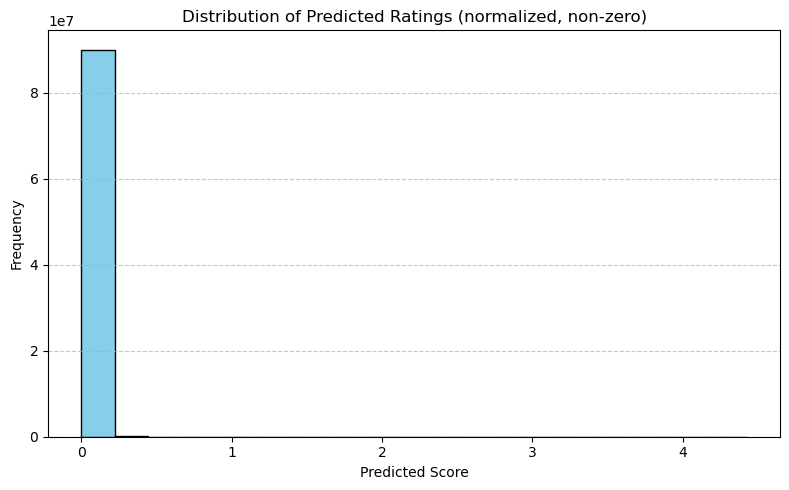

In [ ]:
from matplotlib import pyplot as plt

data = P_sparse.data
data = data[data > 0] 

print("Min value:", data.min()) 
print("Max value:", data.max()) 
print("Mean:", data.mean()) 
print("Standard deviation:", data.std()) 

plt.figure(figsize=(8, 5)) 
plt.hist(
    data, 
    bins=20, 
    edgecolor='black', 
    color='skyblue' 
)
plt.title("Distribution of Predicted Ratings (non-zero)") 
plt.xlabel("Predicted Score") 
plt.ylabel("Frequency") 
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.show() 

In [85]:
P = pd.DataFrame.sparse.from_spmatrix(
    P_sparse,
    index=product_index,
    columns=user_index 
)
P.head() 

,A0072193KFP6LUHKEXLT,A0096681Y127OL1H8W3U,A0103849GBVWICKXD4T6,A0279100VZXR9A2495P4,A0600727NK5MAF66IOY5,A0727497OR0PPNFLFPDV,A07936821FOVJO6NP4Q8,A0833006NJW9KRF77ZFY,A0955928C2RRWOWZN7UC,A10044ECXDUVKS,...,AZYCGMFCK9AIM,AZYJTD9J82V5I,AZYP4FQ2L2C4O,AZZ3WYDJ0XNZW,AZZCLFV6V8693,AZZM5MUOG0LRK,AZZT9G4MJFCHD,AZZX23UGJGKTT,AZZZ3LGTCGUZF,AZZZG8PGB1FS0
0739079891,0.001417,0.002249,0,0,0,0,0.005686,0,0,0.002617,...,0.012907,0,0,0.00569,0.005153,0,0,0,0,0
0786615206,0,0.006382,0,0,0,0,0,0,0,0.001126,...,0,0,0,0,0,0,0,0,0,0
1480360295,0.007739,0.002601,0,0,0,0,0.003764,0.027382,0.00357,0.003489,...,0.020344,0.001097,0,0.001751,0,0,0.000882,0,0,0.019288
1928571018,0.002,0.000598,0,0,0,0,0.000778,0,0,0.000233,...,0,0,0,0.000692,0.007247,0,0,0,0,0.001216
9792372326,0,0,0,0,0,0,0,0,0,0.001631,...,0,0.022063,0,0.000986,0,0,0.002676,0.030343,0.015025,0.008067


Assess distribution of recommendation scores

In [18]:
min = P.min() 

Along with the raw recommendations score we'll also create an approximate predicted rating by denormalizing the values. 

### 3.3.3. Encode Recommendations into Graph

In [86]:
def add_recommendation_edges(graph=G, prediction_matrix=P, min_score=2.5): 
    best_edges = {} 

    for product in P.index: 
        for user in P.columns: 
            score = P.at[product, user]
            # always add a recommendation is predicted rating >= 2.5
            if score >= min_score: 
                G.add_edge(
                    product, 
                    user, 
                    edge_type='Recommended',
                    weight=score
                )
            # else keep track of the highest predicted rating (always add at least one recommendation for each user)
            else: 
                if (user not in best_edges or score > best_edges[user][1]): 
                    best_edges[user] = (product, score) 
    
    # add best available recommendation for users without one 
    existing_recommendees = {
        v for _, v, d in G.edges(data=True) if d.get('edge_type') == 'Recommended'
    }
    for user, (product, score) in best_edges.items(): 
        if user not in existing_recommendees: 
            G.add_edge(
                product,
                user,
                edge_type='Recommended', 
                weight=score
            )
    return G

G = add_recommendation_edges()

In [87]:
import pickle 

graphs_dir = os.path.join(project_dir, "graph") 
with open(os.path.join(graphs_dir, "graph_3.pkl"), 'wb') as f: 
    pickle.dump(G, f) 

### 3.3.4. Reload Graph

In [12]:
import pickle 

graphs_dir = os.path.join(project_dir, "graph")
with open(os.path.join(graphs_dir, "graph_2.pkl"), 'rb') as f: 
    G = pickle.load(f) 

print(type(G)) 

<class 'networkx.classes.digraph.DiGraph'>


In [20]:
os.listdir(data_dir)

NameError: name 'data_dir' is not defined

In [ ]:
data_dir = os.path.join(project_dir, "data")
metadata_path = os.path.join(data_dir, "meta_Musical_Instruments.json.gz") 

# keep 'also_buy' and 'also_bought' fields separate -- treat as edges
edge_fields = ['also_buy', 'also_viewed']
for review in parse(metadata_path): 
    # check if node exists for 'asin' field 
    product_id = review.get('asin', None) 
    if not G.has_node(product_id): 
        continue 
    else: 

        edge

## 3.4. Top-r recommendations lookup

In [11]:
U.head()

,A0072193KFP6LUHKEXLT,A0096681Y127OL1H8W3U,A0103849GBVWICKXD4T6,A0279100VZXR9A2495P4,A0600727NK5MAF66IOY5,A0727497OR0PPNFLFPDV,A07936821FOVJO6NP4Q8,A0833006NJW9KRF77ZFY,A0955928C2RRWOWZN7UC,A10044ECXDUVKS,...,AZYCGMFCK9AIM,AZYJTD9J82V5I,AZYP4FQ2L2C4O,AZZ3WYDJ0XNZW,AZZCLFV6V8693,AZZM5MUOG0LRK,AZZT9G4MJFCHD,AZZX23UGJGKTT,AZZZ3LGTCGUZF,AZZZG8PGB1FS0
0739079891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0786615206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1480360295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1928571018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9792372326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
def get_top_recs(prediction_matrix, utility_matrix, users=None, r=5): 
    """
    Creates a lookup dict for top-r (default 5) recommended products for each user.
    If users set to None (default), compute the full lookup. 
        To get top recs for specific user(s), pass a list of User IDs to users. 
    """
    recommendations = {} 
    if users is None: 
        for user in prediction_matrix.columns: 
            # Filter for items not actually rated by user
            user_preds = prediction_matrix[user][utility_matrix[user] == 0] 
            top_r_items = user_preds.sort_values(ascending=False).head(r) 
            recommendations[user] = top_r_items.index.tolist() 
    elif isinstance(users, str): 
        user_preds = prediction_matrix[user][utility_matrix[user] == 0] 
        top_r_items = user_preds.sort_values(ascending=False).head(r)
        recommendations[user] = top_r_items.index.tolist() 
    elif isinstance(users, list): 
        for user in users: 
            user_preds = prediction_matrix[user][utility_matrix[user] == 0] 
            top_r_items = user_preds.sort_values(ascending=False).head(r) 
            recommendations[user] = top_r_items.index.tolist()  
    else: 
        print("TypeError: users parameter must be None, a string, or list of strings giving User IDs.")
        return False
    
    return recommendations

recs = get_top_recs(P, U) 

In [14]:
# save the recs lookup (json) 
with open(os.path.join(lookups_dir, "top5_recs.json"), 'w') as f: 
    json.dump(recs, f) 

In [7]:
# reload recs lookup 
lookups_dir = os.path.join(project_dir, "lookups")
with open(os.path.join(lookups_dir, "top5_recs"), 'r') as f: 
    recs = json.load(f) 

# 4. LLM Prompting

Given some user u identified by their user_id and k desired recommendations, we want to do the following: 

1. Get the product_ids (p, q etc.) of those k products from the recs lookup. 
2. Find the N set of users who have rated p and are most similar to u. 
3. Finding p review samples: 
    a. If N is insufficiently large, say below three, also find the highest ratings for p with the most votes.  
    b. Regardless of how big N is, find the review of p with highest rating and most votes. 
4. u review sample: Find user u's review with highest rating. 
    

## 4.1. Collect Prompt Info

### 4.1.1. From lookups

In [19]:
for r, v in recs.items():
    print(r, v)
    break

A0072193KFP6LUHKEXLT ['B002UAF1PW', 'B000RNB720', 'B0002E1G5C', 'B0002E1J3Q', 'B0006LOBA8']


to make this even more sophisticated you could use item-item similarity in a complementary way to find the most similar item to the recommended product that user has reviewed. Can also use product info directly. 

In [78]:
I.head()

,0739079891,0786615206,1480360295,1928571018,9792372326,B00000J50W,B00001W0DH,B00001W0DT,B00004TT3S,B00004UE29,...,B01HECB4AG,B01HED0HO4,B01HG0FXAI,B01HG293XO,B01HGLUP14,B01HHJXKRG,B01HHZAU3W,B01HI1VM28,B01HI5M4GW,B01HIDOPP2
0739079891,1.000000,0.0,0.037687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0786615206,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1480360295,0.037687,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1928571018,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9792372326,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
relevant_review_keys = [
    'overall',
    'reviewText',
    'summary',
    'vote',
    'verified'  # still don't know what this means! but it seems important!
]

In [147]:
# helper to rank reviews by similarity score 
def rank_reviews(reviews, similarity_vector): 
    # sort by similarity 
    sorted_keys = sorted(
        reviews,
        key=lambda x: similarity_vector[x],
        reverse=True 
        )
    # replace IDs with ranks 
    ranked_reviews = {
        rank + 1: reviews[key] for rank, key in enumerate(sorted_keys)
    }
    return ranked_reviews

In [148]:
# Helper Function 
def collect_reviews(user_id, product_id, similarity='user', utility_matrix=U, item_matrix=I, user_matrix=S, graph=G, num_reviews=1): 
    
    if similarity == 'user': # looking for similar users to user_id who have rated product_id
        relevant_nodes = utility_matrix.loc[product_id][utility_matrix.loc[product_id] > 0].index.tolist()
        print(f"Users who have rated {product_id}: {relevant_nodes}") 
        similarity_vector = user_matrix.loc[relevant_nodes, user_id] 
        similar_nodes = similarity_vector.sort_values(ascending=False).index.tolist()
        print(f"Users who have rated {product_id} most similar to {user_id}: {similar_nodes}")
        target_node = product_id # we'll be looking for the reviews of product_id from the users in similar_nodes

    elif similarity == 'item':  # looking for similar products to product_id rated by user_id
        relevant_nodes = utility_matrix.loc[:, user_id].gt(0).index.tolist()
        print(f"Products rated by {user_id}: {relevant_nodes}") 
        similarity_vector = item_matrix.loc[relevant_nodes, product_id]
        similar_nodes = similarity_vector.sort_values(ascending=False).index.tolist() 
        print(f"Products rated by {user_id} most similar to {product_id}: {similar_nodes}")
        target_node = user_id # we'll be looking for reviews of similar_nodes (items) from the user_id
    else: 
        raise ValueError("nodetype parameter must be 'user' (default) or 'item'")
    
    done = False
    rating_to_beat = 0 
    reviews = {}

    for s in similar_nodes: 

        if done: 
            return reviews 
        # if reviews contains the number of reviews needed, check whether they're all five star ratings 
        elif len(reviews) == num_reviews: 
            num_good_reviews = 0 
            for r in reviews: 
                if num_good_reviews == num_reviews: 
                    done = True 
                    break
                if reviews[r]['overall'] != 5: 
                    rating_to_beat = reviews[r]['overall']
                    break 
                elif reviews[r]['overall'] == 5:
                    num_good_reviews += 1 
                else:  # if no overall rating, remove this review 
                    del reviews[r] 
        
        if not graph.has_node(s): 
            print(f"Node {s} not in graph") 
            continue 
        # Now we want to find 
        # collect the edge set of node s 
        ## if s is user node, we want the out set 
        ## if s is an item node, we want the in set
        edges = (
            graph.out_edges(s, data=True) 
            if similarity == 'user'  # for user similarity we want out edges
            else graph.in_edges(s, data=True) # and in edges for item similarity
        )
        # iterate through source, target and edge in the edge set of s
        # if similarity is USER, the edge set is the out set of similar users and the target node is product_id
        ## which means the product_id (target_node) is v 

        # conversely, if similarity is ITEM, the edge set is the in set of similar items 
        ## and the target_node is the user_id
        ## which means the the user_id is u
        for u, v, data in edges: 
            if similarity == 'user': 
                connected_node = v 
                key = u
            else: 
                connected_node = u 
                key = v 
            if connected_node != target_node: 
                continue 
            if 'reviewText' not in data: 
                continue 
            if data.get('overall') > rating_to_beat: 
                review_info = {k:v for k, v in data.items() if k in relevant_review_keys}
                # key reviews with IDs -- we'll use later to rank 
                reviews[key] = review_info

                if len(reviews) > num_reviews: 
                    sorted_keys = sorted(reviews, key=lambda x: reviews[x]['overall']) 
                    top_keys = sorted_keys[1:] 
                    reviews = {k: reviews[k] for k in top_keys}
    
    # sort reviews by similarity and rank them 
    ranked_reviews = rank_reviews(reviews, similarity_vector) 

    return ranked_reviews

structure of info: 
{
    product: {}, 
    reviews:{
        similar_users: {

        },
        similar_items: {
            
        },
        most_helpful: {
            
        }
    }
}

In [150]:
def find_most_helpful_review(product_id): 
    """
    Find the most helpful review (by votes) for this product.
    """
    # collect the edge set of product_id 
    in_edges = G.in_edges(product_id, data=True)

    for rating in range(5, 0, -1): 
        most_votes = -1 
        most_helpful = None

        for _, _, review in in_edges: 
            # find most helpful five star review 
            if review.get('overall') == rating:
                votes = review.get('votes', 0) 
                if votes > most_votes: 
                    most_votes = votes
                    most_helpful = {k:v for k, v in review.items() if k in relevant_review_keys}
        
        if most_helpful:
            return most_helpful
        
    return None

In [129]:
relevant_product_keys

['title', 'brand', 'price', 'category', 'description', 'feature']

In [160]:
def find_prompt_info(user_id, graph=G, num_product_reviews=1, num_user_reviews=1, utility_matrix=U, user_similarity_matrix=S, item_similarity_matrix=I, recommendations=recs): 
    
    recommended_product_id = recommendations[user_id][0] 
    product_reviews = collect_reviews(user_id, recommended_product_id, similarity='user', num_reviews=num_user_reviews) # review of product by similar user 
    item_reviews = collect_reviews(user_id, recommended_product_id, similarity='item', num_reviews=num_product_reviews)  # reviews by user of similar products 
    most_helpful_review = find_most_helpful_review(recommended_product_id) 
    product_info = {
        k: v for k, v in G.nodes[recommended_product_id].items() if k in relevant_product_keys
    }
    # structure info in consistent format 
    info = {
        'Product': product_info, 
        'Reviews by similar users': product_reviews, 
        'Helpful review of product': most_helpful_review,
        'Reviews of similar products by user': item_reviews 
    }
    return info

In [ ]:
# test on random node 
import random 

users = U.columns.tolist() 
rand_user = random.choice(users) 
info = find_prompt_info(rand_user) 

Users who have rated B000VJJQUU: ['A10B2J2IRQXBWA', 'A10GEUIRKB6WQJ', 'A10H615T69FJT4', 'A10O6D8F6G4TN8', 'A119H0Z9AF1L78', 'A119J10N0ZEFOB', 'A11GSNHJ26G56T', 'A11KPE3KW3YPLF', 'A129WUT5OMBKG', 'A12CYWQEQWQUE0', 'A12H5NU4NG1GNW', 'A12Q5YQ9VUE163', 'A131C7U5KW268Z', 'A1358HZ2HE6LA3', 'A13BPPMZLBI7LY', 'A13HLORCSR19S0', 'A13MAQOLZNYWLP', 'A13MKC6BVQBYSC', 'A13NIA1DSNNIUA', 'A13XL99Q9M0CB7', 'A13XSFKDUZ7ZAT', 'A14618U5UKIWMK', 'A146LB7C4FUTCW', 'A14K7OOWZJ4ZK3', 'A14OABQ58FB54B', 'A14UND9QWWFJPI', 'A1515RYM86ZU62', 'A15N31K8F1UENK', 'A15PJ8G2B4N6ZV', 'A15YE9AKU4EDYH', 'A163GZFH3J6T5A', 'A1641Z2K8ZUOL0', 'A167RWG02GMUST', 'A16CZHEQUDUE57', 'A16GCM56JY94GF', 'A16GTJ7UN87CFD', 'A16HKNQ3M60UD7', 'A16RWC9FSN572J', 'A16Y9KZ7B3978F', 'A177KOBV19LGSZ', 'A17JRGKZIPT7RK', 'A17NXIPGUUKWDU', 'A17TPFX11NPH3L', 'A1803TC7DCT5ZA', 'A180P22KX8C782', 'A1831MF6FFQ00O', 'A188E2GA1IYVVV', 'A18DBN6BBQK13J', 'A18ODRWLQLSLVD', 'A18PJ1OKFN0W0X', 'A18UX27TFQ9BFN', 'A18W0VKTFN2B0H', 'A19CVVY6HU1APW', 'A19CXLF2PUJG

In [154]:
for k, v in info.items(): 
    print(k, ":", v) 

Product : {'category': ['Musical Instruments', 'Live Sound & Stage', 'Stage & Studio Cables', 'Microphone Cables'], 'description': ['The CBI MLC Cables are built to last and priced to save you big money! An excellent Low-Z microphone cable, the CBI MLC offers high quality XLR male and female connectors and is compatible with any XLR connection-microphones, mixers, recorders. ..or anywhere else you need a high quality XLR connection.'], 'title': 'CBI MLC LowZ XLR Male to XLR Female Microphone Cable, 20 Feet', 'brand': 'CBI Cables', 'feature': ['Microphone cable for studio recording and live sound', 'High-quality XLR male and female connectors; 3-pin XLR male to XLR female', 'Protective metal housing; flexible PVC jacket with 6.0mm outer diameter', 'All copper conductors and inner copper spiral shielding; shielded cable reduces interference and excess noise', 'Measures 20-feet long; backed by a CBI Cables 10-Year Limited Warranty', '<span class="a-size-base a-color-secondary">\n         

In [155]:
for k, v in info['Product'].items(): 
    print(k, ":", v) 

category : ['Musical Instruments', 'Live Sound & Stage', 'Stage & Studio Cables', 'Microphone Cables']
description : ['The CBI MLC Cables are built to last and priced to save you big money! An excellent Low-Z microphone cable, the CBI MLC offers high quality XLR male and female connectors and is compatible with any XLR connection-microphones, mixers, recorders. ..or anywhere else you need a high quality XLR connection.']
title : CBI MLC LowZ XLR Male to XLR Female Microphone Cable, 20 Feet
brand : CBI Cables
feature : ['Microphone cable for studio recording and live sound', 'High-quality XLR male and female connectors; 3-pin XLR male to XLR female', 'Protective metal housing; flexible PVC jacket with 6.0mm outer diameter', 'All copper conductors and inner copper spiral shielding; shielded cable reduces interference and excess noise', 'Measures 20-feet long; backed by a CBI Cables 10-Year Limited Warranty', '<span class="a-size-base a-color-secondary">\n                Quantity: 1\n    

## 4.2. Generate Prompt 

In [156]:
task_prompt = """
### TASK DESCRIPTION: 
Your task is to generate short recommendation tips for Amazon users based on information that will be provided to you in follow up prompts.
The information you will be given is structured in JSON format. 
The structure is as follows:
{
    Product: {<key-value pairs providing information on the recommended product>},
    Reviews by similar users: {
        <Ranked similarity with user, with 1 being the highest rank>: <review data as key value pairs>{
            <overall>: <rating this user gave to the product>, 
            <verified>: <if True, this review is known to derive from a trusted source>, 
            <reviewText>: <the text of the review itself>, 
            <summary>: <a brief summary of the review>
            },
    Reviews of similar product by user: {<same structure as above. These reviews are of the products most similar to the recommended product, and are written by the recomendee user.>}, 
    Helpful review of product: {<same structure as above. This review of the product was voted most helpful by other users.>},
}
Your task is to synthesize this information into a short recommendation tip for the product that is customized for this user. 
-------------------------------------------------------------------------------------------------
Each prompt will represent a separate recommendation task. 

This prompt is only to inform you of the task. 
If you understand the task, please return a brief message verifying your understanding. 
If you do not understand the task, please return a brief message explaining your confusion.
"""

## 4.3. Gemini 

Note: Gemini 2.5 Pro Experiment is limited to 1 request per minute and 1000 requests per day. 

### 4.3.1. With requests

In [159]:
import requests
import json 
from dotenv import load_dotenv 

env_path = os.path.join(project_dir, ".env") 
load_dotenv(env_path) 

gemini_api_key = os.getenv('OPENROUTER_API_KEY')

response = requests.post(
    url="https://openrouter.ai/api/v1/chat/completions", 
    headers={
        "Authorization": f"Bearer {gemini_api_key}",
        "Content-Type": "application/json" 
    }, 
    data = json.dumps({
        "model": "google/gemini-2.5-pro-exp-03-25:free",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text", 
                        "text": task_prompt
                    }
                ]
            }
        ]
    })
)

print("---Prompt---") 
print(task_prompt)
print("\n---Model Response ---") 
try: 
    result = response.json() 
    message = result['choices'][0]['message']['content'] 
    print(message) 
except Exception as e: 
    print("Error extracting model response:", e) 
    print("Raw response:", response.text) 

---Prompt---

### TASK DESCRIPTION: 
Your task is to generate short recommendation tips for Amazon users based on information that will be provided to you in follow up prompts.
The information you will be given is structured in JSON format. 
The structure is as follows:
{
    Product: {<key-value pairs providing information on the recommended product>},
    Reviews by similar users: {
        <Ranked similarity with user, with 1 being the highest rank>: <review data as key value pairs>{
            <overall>: <rating this user gave to the product>, 
            <verified>: <if True, this review is known to derive from a trusted source>, 
            <reviewText>: <the text of the review itself>, 
            <summary>: <a brief summary of the review>
            },
    Reviews of similar product by user: {<same structure as above. These reviews are of the products most similar to the recommended product, and are written by the recomendee user.>}, 
    Helpful review of product: {<same 

With Langchain 

In [1]:
# create gemini instance
import os
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAI

gemini = GoogleGenerativeAI(
    model="gemini-2.0-flash-lite", 
    google_api_key=os.getenv("GEMINI_API_KEY"),
    temperature=0.5
)

In [2]:
print(gemini.invoke(
    "Please confirm that I am speaking with gemini-2.0-flash-lite."
))

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised PermissionDenied: 403 Request had insufficient authentication scopes. [reason: "ACCESS_TOKEN_SCOPE_INSUFFICIENT"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
metadata {
  key: "method"
  value: "google.ai.generativelanguage.v1beta.GenerativeService.GenerateContent"
}
].


PermissionDenied: 403 Request had insufficient authentication scopes. [reason: "ACCESS_TOKEN_SCOPE_INSUFFICIENT"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
metadata {
  key: "method"
  value: "google.ai.generativelanguage.v1beta.GenerativeService.GenerateContent"
}
]

In [ ]:
# check API is accessible 
import os 
from google import genai 

client = genai.Client(
    api_key=os.getenv("GEMINI_API_KEY"),
    
    ) 

response = client.models.generate_content(
    model="gemini-2.0-flash", 
    contents="""
        Please simply confirm that I have successfully called the gemini-2.0-flash API.
"""
)

print(response.text) 

ValueError: Missing key inputs argument! To use the Google AI API, provide (`api_key`) arguments. To use the Google Cloud API, provide (`vertexai`, `project` & `location`) arguments.